## Test MLE on a fake Batchelor spectrum.
### Question: What is the influence of variable degrees of freedom?

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext fortranmagic

/usr/local/anaconda3/envs/epsilon-env/lib/python3.7/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

In [3]:
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

from scipy.optimize import minimize

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [4]:
ds = xr.open_dataset('../data/chi/variable_dof.nc')

In [5]:
def logbin_data(f_cps, k_rpm, logbins, chi, kb, p, function):
    import bottleneck as bn

    if function=='batchelor':
        fun = batchelor
    elif function=='kraichnan':
        fun = kraichnan
        
    digit = np.digitize(f_cps, logbins)
    ks=[]
    bs=[]
    count=[]
    for i in range(len(logbins)):
        ks.append( bn.nanmedian( k_rpm[digit==i]) )
        bs.append( bn.nanmedian( fun( k_rpm[digit==i], chi, kb, p ) ))
        count.append(bn.nansum(digit==i))

    return np.array(ks), np.array(bs), np.array(count)

In [6]:
def cost_function(kb, k_rpm, chi, noise, corrdTdz, dof, function, bin_theory):
    '''
    Cost function for MLE to fit spectra
    
    log chi2 rewritten from scipy.chi2._logpdf
    '''
    import bottleneck as bn
    from epsilon_tools import  kraichnan, batchelor
    from scipy.special import xlogy, gammaln
    import numpy as np
    import math

    if function.lower() == 'batchelor':
        fun = batchelor
    elif function.lower() == 'kraichnan':
        fun = kraichnan
    elif function.lower() == 'power':
        theory = kb[0]*k_rpm**(-kb[1])
    else:
        raise ValueError('Function not known!')
    
    if bin_theory:
        logbins = np.logspace(-1,1.7,20)
        f_cps = np.linspace(0,60,5000)
        k_rpm = f_cps* 2 * np.pi/w
        digit = np.digitize(f_cps, logbins)
    
        bs=[]
        for i in range(len(logbins)):
            bs.append( bn.nanmedian( fun( k_rpm[digit==i], chi, kb, p ) ))

        theory = np.array(bs)
 
    else:
        theory = fun(k_rpm, chi, kb, p)
        
    a =  dof / (theory + noise)
    b = corrdTdz * a
    
    summe = -np.nansum(np.log(a)) - np.nansum(xlogy(dof/2-1, b)) +\
            np.nansum(b/2) + np.nansum(gammaln(dof/2.) + (math.log(2)*dof)/2)
    return summe

In [7]:
def noise_spectrum(f_cps):
    ''' 
    Empirical noise spectrum
    '''
    para = 20 # previously 15
    return 1e-11 * (1 + (f_cps / para)**3)**2

### $\phi_{\frac{dT}{dz}}$ as a function of $k_b$ and $\chi$

In [8]:
def plot_batchelor_and_kraichnan():
    p = Parameters()
    f,ax = plt.subplots(1,2, figsize=(15,6), sharey=True)

    colors = sns.color_palette(n_colors=4)

    k_rpm = np.logspace(-1,3)
    fixed_kb = 400
    variable_chi = [1e-7,1e-8,1e-9,1e-10]

    for i,chi in enumerate( variable_chi ):
        ax[0].plot(k_rpm, kraichnan(k_rpm,chi, fixed_kb, p), label=rf'$\chi$ = {chi}', color=colors[i])
        ax[0].plot(k_rpm, batchelor(k_rpm,chi, fixed_kb, p), label=f'_{chi}', lw=1, ls='dotted', color=colors[i])

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Fixed k$_b$, variable $\chi$')
    ax[0].set_ylabel('Temperature gradient spectrum')
    ax[0].set_xlabel('k$_z$')
    ax[0].set_ylim(1e-12,1e-2)
    ax[0].legend()

    variable_kb = [300, 400, 500, 600]
    fixed_chi = 1e-9
    for i,kb in enumerate(variable_kb):
        eps = kb**4*p.D**2*p.nu
        ax[1].plot(k_rpm, kraichnan(k_rpm,fixed_chi, kb, p), label=rf'$k_b$ = {kb} $\rightarrow$ $\epsilon$ = {eps:1.2e}', color=colors[i])
        ax[1].plot(k_rpm, batchelor(k_rpm,fixed_chi, kb, p), label=f'_{kb}', lw=1, ls='dotted', color=colors[i])

    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title('Fixed $\chi$, variable k$_b$')
    ax[1].set_xlabel('k$_z$')
    ax[1].legend()

    plt.subplots_adjust(wspace=0.1)
    plt.savefig('../figures/kraichnan_model.pdf')
    plt.show()

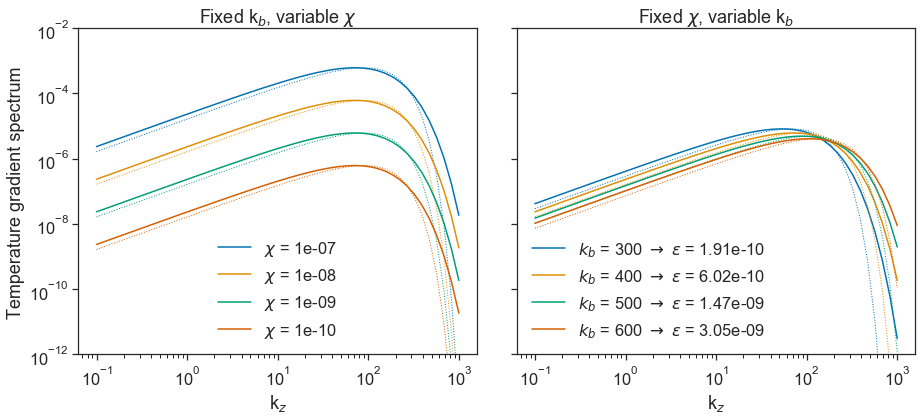

In [9]:
plot_batchelor_and_kraichnan()

### Recipe:
1. create continuous batchelor spectrum choosing k$_b$ and $\chi$
2. bin the spectrum in frequency space
3. apply MLE to find k$_b$
    a) with variable degrees of freedom
    b) with fixed degrees of freedom
4. compare estimated k$_b$ to true k$_b$

Cost function

$$
\begin{align}
S_{theory} = S_{kraichnan} + S_{noise}\\
C11 = \sum \log \frac{d}{S_{theory}} \chi^2_d \left( \frac{dS_{obs}}{S_{theory}} \right)
\end{align}
$$

In [10]:
def visualize_mle(kb, function):
    bin_theory='false'
    f,ax = plt.subplots(1,2, figsize=(12,6))
    if function.lower() == 'batchelor':
        theory = batchelor
    elif function.lower() == 'kraichnan':
        theory = kraichnan
        
    k_bin, b_bin, count = logbin_data(f_cps,k_rpm, logbins, chi, kb_true, p, function)
    noise = 1e-9*np.ones_like(k_bin)
    
    ax[0].loglog(k_rpm, theory(k_rpm, chi, kb_true, p) ,label='True', ls='dotted', lw=0.5, color='k')
    ax[0].loglog(k_rpm, theory(k_rpm, chi, kb, p) ,label='Estimate')
    ax[0].loglog(k_bin, b_bin, 'o',label='Sampled')
    ax[0].legend()
    ax[0].set_title('T gradient spectra')
    ax[0].set_xlabel(r'k$_z$ [rpm]')
    ax[0].set_ylabel(r'$\phi_{\frac{dT}{dz}}$ [K$^{2}$m$^{-1}$]')
    ax[0].set_ylim(1e-12,1e-3)
    
    ind = int( np.argwhere( kbs==kb ) )+1
    c11 = [-cost_function(ks, k_bin, chi, noise, b_bin, dof, function, False) for ks in kbs]
    c11s = [-cost_function(ks, k_bin, chi, noise, b_bin, dof, function, False) for ks in kbs[:ind] ]
    cmax = np.nanmax(c11)
    
    ax[1].plot(kbs[:ind], c11s/cmax ,'-')
    ax[1].plot(kb, -cost_function(kb, k_bin, chi, noise, b_bin, dof, function, False)/cmax,'o', label='C(kb)')
    ax[1].plot(kbs, c11/cmax,'-', ls='dotted', lw=0.5, color='k')
    
    ax[1].legend()
    ax[1].set_xlim(np.min(kbs),np.max(kbs))
#     ax[1].set_ylim(240,np.nanmax(c11s)+5)
    ax[1].set_xlabel(r'k$_b$ [rpm]')
    ax[1].set_title('Cost function C11')
    return 

In [20]:
p = Parameters()
chi=1e-8

w = 0.1

dof=2
logbins = np.logspace(-1,1.7,20)

f_cps = np.linspace(0,60,5000)
k_rpm = f_cps* 2 * np.pi/w
kbs = np.arange(250,600,10)
kb_true = 350
interactive(visualize_mle,kb=IntSlider(min=250,max=600, step=10, value=300), function = ['kraichnan','batchelor'])

interactive(children=(IntSlider(value=300, description='kb', max=600, min=250, step=10), Dropdown(description=…

In [12]:
def trial_eps_estimation(f_cps, kbs, variable_dof, function, bin_theory):
    p = Parameters()
    chi=1e-8
    w = 0.1

    logbins = np.logspace(-1,1.7,20)
#     logbins = np.logspace(-1,1.7,100)
    #logbins = ds.f_cps.values

    estimated_kb = []
    for kb in kbs:
        k_rpm = f_cps* 2 * np.pi/w
        k_bin, b_bin, count = logbin_data(f_cps,k_rpm, logbins, chi, kb, p, function)

        if variable_dof:
            #dof = np.round( ds.isel(time=0).dof.values )
            dof = 2*count
        else:
            dof = 2
        
        noise = 0 #1e-9*np.ones_like(k_bin)
#         noise = k_bin**2*noise_spectrum(k_bin*w/(2*np.pi))*w/ (2 * np.pi)
        
        args = (k_bin, chi, noise, b_bin, dof, function, bin_theory)
        options = {'maxiter':1000,'xatol':1e-5,'fatol':1e-5}
        m = minimize(cost_function, x0=300, args=args, method='Nelder-Mead', options=options)
        if m.success:
            estimated_kb.append(m.x)
        else:
#             print(f'{m.message}')
            estimated_kb.append(np.nan)
    
    print(f'Done with {function}, variable_dof={variable_dof}, bin_theory={bin_theory}')
    return np.array( estimated_kb ).flatten().astype(float)

def epsilon(kb):
    return kb**4 * p.nu * p.D**2

def eps2kb(eps):
    return (eps/(p.nu * p.D**2))**(1/4)

def make_arrow_annotation(ax, datatuple , offsettuple, **kwargs):
    ax.annotate(r'initial guess for x$_0$',
            xy=datatuple, xycoords='data',
            xytext=offsettuple, textcoords='offset points',
            arrowprops=dict(arrowstyle='->',color='k'),
            horizontalalignment='right', verticalalignment='bottom', fontsize=15, clip_on=True, **kwargs)

In [21]:
def plot_kb_estimation(eyes=False):
    f, ax = plt.subplots(1,2, figsize=(15,6), sharex='col')

    ax = ax.flatten()
    ax[0].plot(kbs, 100*(fixed-kbs)/kbs,label='fixed dof,  Kraichnan')
    ax[0].plot(kbs, 100*(fixedb-kbs)/kbs, ls='dotted', label='fixed dof, Batchelor')
    ax[0].plot(kbs, 100*(variable - kbs)/kbs , label='variable dof, Kraichnan')
    ax[0].plot(kbs, 100*(variableb - kbs)/kbs , ls='dotted', label='variable dof, Batchelor')

    ax[0].set_ylabel(r'percent error (E[k$_b$] - k$_b$)/k$_b$ [%]')
    # ax[0].set_xlabel(r'true k$_b$');
    ax[0].set_title('kb estimation')
    ax[0].axvline(300, color='k', ls='dotted')
    ax[0].axhline(0, color='k', lw=0.5)
#     make_arrow_annotation(ax[0], (500,1), (-15,25))
    ax[0].legend()

    if eyes:
        ax[0].plot(600,3.2e-4, 'o', markersize=10, color='k')
        ax[0].plot(590,3.2e-4, 'o', markersize=10, color='k')
    ax[0].annotate("", (590,2.9e-4), xycoords='data', fontsize=50,)
    ax[1].plot( epsilon(kbs), 100*(epsilon( fixed)-epsilon(kbs))/epsilon(kbs) )
    ax[1].plot( epsilon(kbs), 100*(epsilon( fixedb)-epsilon(kbs))/epsilon(kbs), ls='dotted')

    ax[1].plot( epsilon(kbs), 100*(epsilon( variable)-epsilon(kbs))/epsilon(kbs) )
    ax[1].plot( epsilon(kbs), 100*(epsilon( variableb)-epsilon(kbs))/epsilon(kbs) , ls='dotted')

    ax[1].set_ylabel(r'percent error (E[$\epsilon$] - $\epsilon$)/$\epsilon$ [%]')
    # ax[1].set_xlabel(r'true $\epsilon$');
    ax[1].set_xscale('log')
    ax[1].set_title('epsilon estimation')
    ax[1].axhline(0,color='k', lw=0.5)

    plt.subplots_adjust()
    plt.tight_layout()
    plt.savefig('../figures/fake_batchelor.pdf')
    plt.show()

### Plot percent error between estimated in true k$_b$

In [23]:
p = Parameters()
kbs = np.linspace(200,600)
f_cps = np.linspace(0,60,5000)
k_rpm = f_cps* 2 * np.pi/w

In [24]:
variable = trial_eps_estimation(f_cps, kbs, True, 'kraichnan', True)
fixed = trial_eps_estimation(f_cps, kbs, False, 'kraichnan', True)
variableb = trial_eps_estimation(f_cps, kbs, True, 'batchelor', True)
fixedb = trial_eps_estimation(f_cps, kbs, False, 'batchelor', True)

Done with kraichnan, variable_dof=True, bin_theory=True
Done with kraichnan, variable_dof=False, bin_theory=True
Done with batchelor, variable_dof=True, bin_theory=True
Done with batchelor, variable_dof=False, bin_theory=True


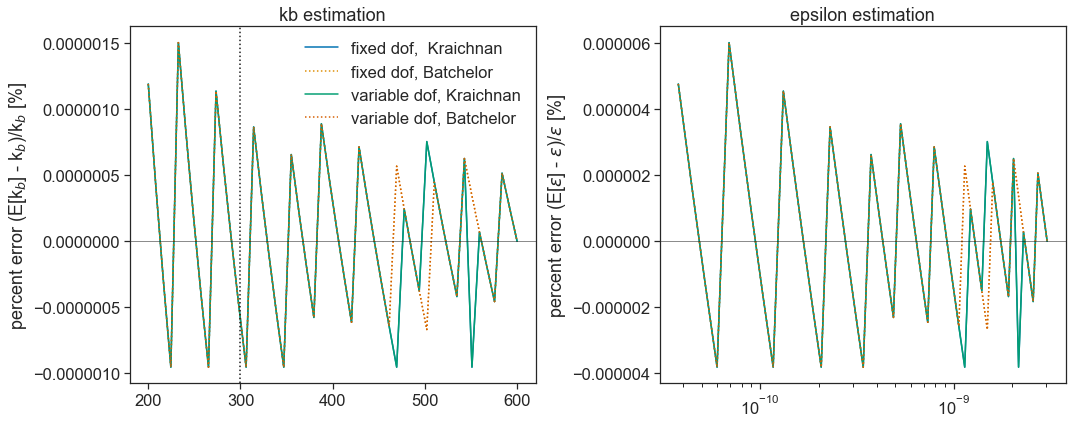

In [25]:
plot_kb_estimation()

In [ ]:
variable = trial_eps_estimation(f_cps, kbs, True, 'kraichnan', False)
fixed = trial_eps_estimation(f_cps, kbs, False, 'kraichnan', False)
variableb = trial_eps_estimation(f_cps, kbs, True, 'batchelor', False)
fixedb = trial_eps_estimation(f_cps, kbs, False, 'batchelor', False)

Done with kraichnan, variable_dof=True, bin_theory=False
Done with kraichnan, variable_dof=False, bin_theory=False


In [ ]:
plot_kb_estimation(eyes=True)
